## Neuronal Network Generator

The Neronal Network can be configured. The variables that can be adjusted. \
The starting point was the simple creation of a neural network with various parameters, providing a flexible testing platform. 
In the second step, the K-Fold Cross-Validation functionality was added. Through this configuration interface, you can enable or disable K-Fold. 

If a number is specified for the K-Fold parameter, the program will execute the corresponding number of folds. If it is set to `False`, a simple neural network will be created, trained, and executed based on the configured parameters.

In [1]:
# %pip install tensorflow
# %pip install keras

# %pip install --upgrade keras
# %pip install --upgrade keras-cv
# %pip install --upgrade keras-hub
# %pip install --upgrade keras
# %pip install --upgrade typing_extensions



# Config for the Neural Network
KFOLD                           = 6             # N-Fold Cross Validation | "False" can deactivate KFold -> single training
EPOCHS                          = 8             # rounds of training
LEARNING_RATE                   = 0.001         # 0.001 is the default value for Adam Optimizer
BATCH_SIZE                      = 600           # after n samples, weights will be updated
SAVE_MODELS_AND_WEIGHTS         = False         # Saves all Models&Weights in a folder from each KFold

# Config for 1 or 2 Hidden Layers in the Neural Network | True = ON, False = OFF
Layer_ONE                       = True
Layer_TWO                       = True

# Neurons
HiddenLayer_ONE_Neurons         = 32
HiddenLayer_TWO_Neurons         = 16
Output_Neurons                  = 10   # Assuming MNIST digits: 10 output classes

# 0 = sigmoid, 1 = tanh, 2 = relu, 3 = leaky relu (in progress), 4 = softmax 
ChooseActivationFunction_ONE    = 2 
ChooseActivationFunction_TWO    = 2 
ChooseActivationFunction_OUTPUT = 4 

# Imports 
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time  

## Data Import and Preparation

Initially, the MNIST dataset is loaded, consisting of a total of 60,000 images with a resolution of 28x28 pixels. 

In a **single-run scenario (NOT KFOLD)**, the dataset is directly divided into training and test sets.

 However, when K-Fold Cross Validation is set, the data is partitioned into several folds, and in each iteration one fold is used as the validation set while the remaining folds serve as the training set.


In [2]:
if KFOLD:
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # Verify that the datasets have the expected shapes.
    assert x_train.shape == (60000, 28, 28)  # Training set 60,000 images.
    assert y_train.shape == (60000,)         # Training labels
else:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    assert x_train.shape == (60000, 28, 28) 
    assert x_test.shape  == (10000, 28, 28)
    assert y_train.shape == (60000,)
    assert y_test.shape  == (10000,)


# Model Configuration
This section shows the configuration of the neural network. The network architecture supports a maximum of **two hidden layers** in addition to **one output layer**. 

For the hidden layers, you can choose from various activation function options including sigmoid, tanh, **relu**, and softmax. The selected activation functions are applied according to the specific layer configuration. For Tersting purpose.

Additionally, the EarlyStopping callback is utilized for training. This callback monitors the validation loss, and **if no improvement is observed** for a set number of epochs (2), training **stops** early **to prevent overfitting.**

In [3]:
# For defining the activation functions in the model
# Prepared for Max 2 Hidden Layers and 1 Output Layer

# Layer ONE Activation
# ------------------------------------------------
def Layer_ONE_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return "failed"
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

# Layer 2 Activation
# ------------------------------------------------
def Layer_TWO_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return "failed"
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

# Output Layer Activation
# ------------------------------------------------
def OUTPUT_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return "failed"
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"


#------------------------------------------------------------------------------
# Model CONFIGURATION
#------------------------------------------------------------------------------
def create_model():
  if Layer_ONE:
    activation_one = Layer_ONE_ACTIVATION(ChooseActivationFunction_ONE)

  if Layer_TWO:
    activation_two = Layer_TWO_ACTIVATION(ChooseActivationFunction_TWO)

  if Output_Neurons: 
    activation_output = OUTPUT_ACTIVATION(ChooseActivationFunction_OUTPUT)

  layers = [
    tf.keras.layers.Input(shape=(28, 28, 1)), # Input Layer
    tf.keras.layers.Flatten()                 # for 28x28x1 -> 784
  ]

  if Layer_ONE:
    layers.append(tf.keras.layers.Dense(HiddenLayer_ONE_Neurons, activation=activation_one)) 

  if Layer_TWO:
    layers.append(tf.keras.layers.Dense(HiddenLayer_TWO_Neurons, activation=activation_two))

  layers.append(tf.keras.layers.Dense(Output_Neurons, activation=activation_output))

  model = tf.keras.Sequential(layers) # Create the model

  # Compile the model with the specified functions
  model.compile(
  optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

  return model
# end create_model()

# K-Fold loops create a model for each fold and train it.
if KFOLD:
  print("KFOLD")
  pass

# Single Version needs only one model and callback
if not KFOLD:
  print("NOT KFOLD")
  model = create_model()
  
  # Callback seperated for KFold and Single Version | later as variable
  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',        # Metric to be monitored.
      patience= 2,               # Number of epochs to wait for improvement before stopping.
      restore_best_weights=True  # Restore model weights from the epoch with the best monitored metric.
  )

  

KFOLD


### K-Fold Cross-Validation
- **When `KFOLD` is set to a number (e.g., `5`)**:
  - The dataset is split into `K` folds using `KFold` from `sklearn.model_selection`.
  - For each fold:
    - A new model is created using the `create_model()` function.
    - The training data is normalized (divided by 255.0) and split into training and validation sets for the current fold.
    - The model is trained on the training data for the specified number of epochs (`EPOCHS`) and batch size (`BATCH_SIZE`), with early stopping enabled.
    - The training time for each fold is measured and stored in `fold_training_times`.
    - The model's performance on the validation data is evaluated, and the accuracy is stored in `fold_accuracies`.
    - If `SAVE_MODELS_AND_WEIGHTS` is enabled, the trained model and its weights are saved to the `Models` directory for later use.
  - The training history for each fold is stored in the `histories` list for further analysis or visualization.

### Single Training Run
- **When `KFOLD` is set to `False`**:
  - The entire training dataset (`x_train`, `y_train`) is used to train the model.
  - The model is trained for the specified number of epochs and validated on the test dataset (`x_test`, `y_test`).
  - The training time is measured and printed.
  - The model's performance on the test data is evaluated, and the results are displayed.
  - If `SAVE_MODELS_AND_WEIGHTS` is enabled, the trained model and its weights are saved to the `Models` directory.
>note: Callback later a Variable

This setup allows for flexible use with both K-Fold Cross-Validation and single training runs.

In [4]:


if KFOLD:
  kfold = KFold(n_splits=KFOLD, shuffle=True)
  fold_accuracies = []      # store accuracies for each fold
  histories = []            # list of History objects | for Printing
  fold_training_times = []  # store training time for each fold
  i = 0                     # counter for saving models and weights | if SAVE_MODELS_AND_WEIGHTS

  for train_idx, val_idx in kfold.split(x_train):
    model = create_model()                              # new model for this run
    early_stop = tf.keras.callbacks.EarlyStopping()     # new early stopping for this run | Callback seperated for KFold and Single Version | later as variable | https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

    x_train_fold, x_val_fold = x_train[train_idx]/255.0, x_train[val_idx]/255.0   # normalize the data
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]               # get the labels

    start_time = time.time()
    history = model.fit(
      x_train_fold, y_train_fold,                     # training data for this fold
      validation_data=(x_val_fold, y_val_fold),       # validation data for this fold
      epochs=EPOCHS,                                  # number of epochs to train
      batch_size=BATCH_SIZE,                          # after how many samples to update the weights
      callbacks=[early_stop]                          # backpropagation with early stopping
    )

    # Measure the time taken for training this fold + save in fold_training_times[]
    end_time = time.time()
    elapsed_time = end_time - start_time
    fold_training_times.append(elapsed_time)
    print(f"Fold training time: {elapsed_time:.2f} seconds")
  
    histories.append(history)                               # Save the history object for later analysis
    loss, accuracy = model.evaluate(x_val_fold, y_val_fold) # Evaluate model on validation data
    fold_accuracies.append(accuracy)                        # Save the accuracy for this fold

    if SAVE_MODELS_AND_WEIGHTS:                             # was for testing with single models after training
      os.makedirs("Models", exist_ok=True)
      model.save(f"Models/saved_model_{i}.keras")
      model.save_weights(f"Models/saved_weights_{i}.weights.h5")
      i += 1
  
else:
  start_time = time.time() 
  history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"Training time: {elapsed_time:.2f} seconds")
  loss, accuracy = model.evaluate(x_test, y_test)

  if SAVE_MODELS_AND_WEIGHTS:                             # was for testing with single models after training
    os.makedirs("Models", exist_ok=True)
    model.save(f"Models/saved_model_.keras")
    model.save_weights(f"Models/saved_weights_{i}.weights.h5")


Epoch 1/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3865 - loss: 1.7569 - val_accuracy: 0.8287 - val_loss: 0.5926
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.4984 - val_accuracy: 0.8907 - val_loss: 0.3841
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9040 - loss: 0.3447 - val_accuracy: 0.9081 - val_loss: 0.3154
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9196 - loss: 0.2824 - val_accuracy: 0.9217 - val_loss: 0.2755
Epoch 5/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9303 - loss: 0.2457 - val_accuracy: 0.9291 - val_loss: 0.2511
Epoch 6/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9355 - loss: 0.2232 - val_accuracy: 0.9345 - val_loss: 0.2290
Epoch 7/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9437 - loss: 0.1964 - val_accuracy: 0.9348 - val_loss: 0.2201
Epoch 8/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9470 - loss: 0.1842 - val_accuracy: 0.9389 - val_loss: 0.2082


## Visualization

The visualization of the training process is here presented. All necessary data, such as training loss, training accuracy, validation loss, and validation accuracy, are graphically represented.

Single graph was implemented as a starting point. In the second phase, scaling across multiple folds (N-Folds) and splitting into rows were introduced.



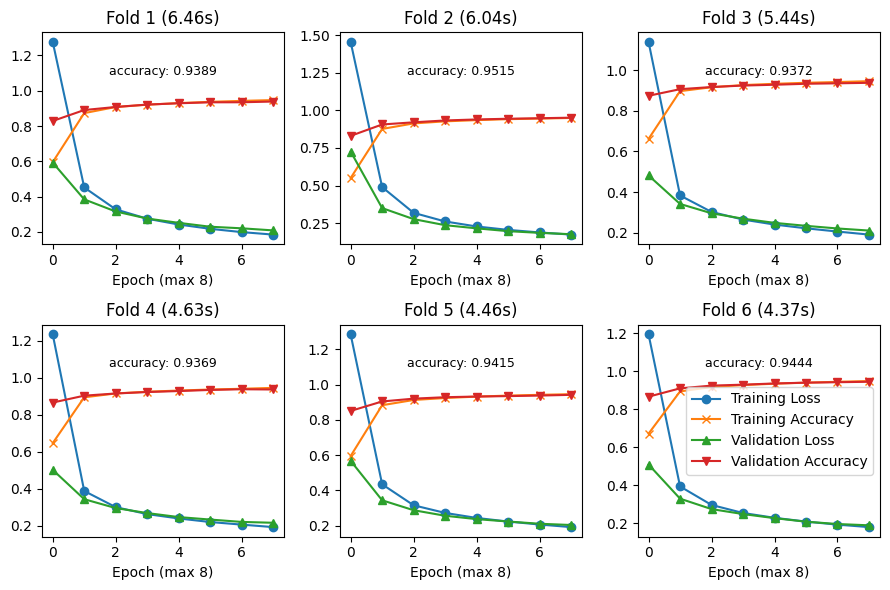

In [5]:
if KFOLD:
    n_folds = len(histories)
    if n_folds >= 5:
        cols = (n_folds + 1) // 2  
        rows = 2
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1, n_folds, figsize=(n_folds * 2, 2))
        if n_folds == 1:
            axs = [axs]

    for i, hist in enumerate(histories):
        ax = axs[i]
        ax.plot(hist.history['loss'], marker='o', label='Training Loss')
        ax.plot(hist.history['accuracy'], marker='x', label='Training Accuracy')
        ax.plot(hist.history.get("val_loss", [None]*len(hist.history['loss'])), marker='^', label='Validation Loss')
        ax.plot(hist.history.get("val_accuracy", [None]*len(hist.history['accuracy'])), marker='v', label='Validation Accuracy')
        ax.set_xlabel(f'Epoch (max {EPOCHS})')
        ax.set_title(f'Fold {i+1} ({fold_training_times[i]:.2f}s)')
        ax.text(0.5, 0.8, f"accuracy: {fold_accuracies[i]:.4f}", transform=ax.transAxes, ha='center', fontsize=9)

    if len(axs) > n_folds:
        for ax in axs[n_folds:]:
            fig.delaxes(ax)
            
    plt.legend() # The legend of the graphs is always displayed within a single graph. I was unable to display it separately in a way that looks visually appealing.
    plt.tight_layout()
    plt.show()

else:
    plt.figure(figsize=(3,2))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.plot(history.history['accuracy'], marker='x', label='Training Accuracy')
    plt.plot(history.history.get("val_loss", [None]*len(history.history['loss'])), marker='^', label='Validation Loss')
    plt.plot(history.history.get("val_accuracy", [None]*len(history.history['accuracy'])), marker='v', label='Validation Accuracy')
    plt.xlabel(f'Epoch (max {EPOCHS})')
    plt.title(f'Training (time: {elapsed_time:.2f}s)')
    plt.legend()
    plt.show()


### Interpreting Data Consistency

If the diagram & table illustrates that if all folds exhibit similar validation accuracy (for instance, within a ±0.5% range), the model shows stability across different subsets of the data.

large variations in validation accuracy, a spread from 85% to 94% suggest potential for imbalance in the dataset or that the validation sets are too small to provide reliable estimates.

In [6]:
# Loop through each history object from K-Fold training
for i, hist in enumerate(histories, 1):  # Enumerate histories, fold count starting from 1
    epochs = range(1, len(hist.history['loss']) + 1)  # List of epoch numbers from 1 to total epochs
    header = f"{'Epoch':<5} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}"  # Header for metrics table
    print(f"Results for Fold {i}:")  # Show current fold
    print(header)  # Print table header
    for epoch, loss, acc, v_loss, v_acc in zip(
            epochs,
            hist.history['loss'],
            hist.history['accuracy'],
            hist.history.get("val_loss", [None]*len(epochs)),  # Safely retrieve validation loss or fill with None
            hist.history.get("val_accuracy", [None]*len(epochs))):  # Safely retrieve validation accuracy or fill with None
        v_loss_str = "None" if v_loss is None else f"{v_loss:.4f}"  # Format validation loss with 4 decimals or "None"
        v_acc_str = "None" if v_acc is None else f"{v_acc:.4f}"  # Format validation accuracy with 4 decimals or "None"
        print(f"{epoch:<5} {loss:<12.4f} {acc:<12.4f} {v_loss_str:<12} {v_acc_str:<12}")  # Output metrics formatted per epoch
    print()  # Blank line to separate folds


Results for Fold 1:
Epoch Train Loss   Train Acc    Val Loss     Val Acc     
1     1.2767       0.5957       0.5926       0.8287      
2     0.4518       0.8733       0.3841       0.8907      
3     0.3275       0.9078       0.3154       0.9081      
4     0.2745       0.9209       0.2755       0.9217      
5     0.2416       0.9301       0.2511       0.9291      
6     0.2172       0.9372       0.2290       0.9345      
7     0.1986       0.9427       0.2201       0.9348      
8     0.1845       0.9472       0.2082       0.9389      

Results for Fold 2:
Epoch Train Loss   Train Acc    Val Loss     Val Acc     
1     1.4545       0.5506       0.7264       0.8307      
2     0.4901       0.8767       0.3506       0.9063      
3     0.3191       0.9133       0.2775       0.9207      
4     0.2618       0.9271       0.2372       0.9330      
5     0.2286       0.9352       0.2162       0.9397      
6     0.2059       0.9416       0.1974       0.9444      
7     0.1889       0.9455      

<h1 style="font-weight: bold;">This is my personal test code</h4>
<div style="display: flex; align-items: center;">
     <img src="https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true" 
           style="width:10%; margin-right: 20px;" 
           alt="Deep Learning Test Image 4">
     <img src="https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true" 
           style="width:10%; margin-right: 20px;" 
           alt="Deep Learning Test Image 2">
     <img src="https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true" 
           style="width:10%; margin-right: 20px;" 
           alt="Deep Learning Test Image 1">
     <p>
           It opens images <a href="https://github.com/Nr44suessauer/nr44suessauer.github.io/tree/main/assets/img/DeepLearningTest" target="_blank">from my GitHub</a>, preprocesses them by converting them to 
           grayscale and resizing them to 28x28 pixels (they are already 28x28), and then uses <strong>the LAST trained model</strong> to predict the class of each image. 
           The output displays both the predicted classes and their corresponding probabilities.
     </p>
</div>

In [7]:
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display

urls = [
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true"
]

# Takes last model from KFold or the model trained on the full dataset
for idx, url in enumerate(urls):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            print(f"Image {idx+1} loaded from: {url}")
            display(img)
            
            # Convert to grayscale and resize to 28x28
            img_proc = img.convert("L").resize((28, 28)) # RGB(RGB) to grayscale (L)
            
            # Prepare the image for the model: normalize and add dimensions
            img_arr = 1.0 - np.array(img_proc) / 255.0 
            img_arr = img_arr.reshape(1, 28, 28, 1)
            
            # Get prediction from the model
            probs = model.predict(img_arr) # Get the probabilities for each class
            pred_class = np.argmax(probs)  # Get the class with the highest probability
            
            print(f"Predicted class: {pred_class}")
            print(f"Probabilities: {probs}")
        else:
            print(f"Failed to load image {idx+1} from: {url} with status code {response.status_code}")
    except Exception as e:
        print(f"Error processing image {idx+1} from {url}: {e}")


Image 1 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predicted class: 3
Probabilities: [[2.8028672e-03 1.4296746e-02 1.8294902e-01 6.2587959e-01 2.6092334e-03
  1.7869677e-02 1.3866721e-01 1.8717246e-03 1.2538664e-02 5.1522051e-04]]
Image 2 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: 1
Probabilities: [[0.00270588 0.31873628 0.03563303 0.11884644 0.00076786 0.05827775
  0.00422589 0.26214924 0.09973329 0.09892438]]
Image 3 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted class: 3
Probabilities: [[1.7604021e-03 8.0037802e-02 2.0179097e-01 6.1470443e-01 2.5760444e-04
  4.8230253e-02 3.3637542e-02 3.7264263e-03 1.5302199e-02 5.5232405e-04]]
Image 4 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: 6
Probabilities: [[0.00366641 0.02327697 0.13750689 0.03258786 0.00807103 0.22952305
  0.39597744 0.00052329 0.16803268 0.00083432]]


## Examples

In the next section, I test with configurations, including different activation functions, varying numbers of neurons, and different numbers of hidden layers. In the next section, I test with configurations, including different activation functions, varying numbers of neurons, and different numbers of hidden layers. 
The input and output of the model remained the same throughout these tests to analyze the impact of these changes on the model's performance. \
[Link to Code Repository](https://github.com/Nr44suessauer/DeepLearning_assignment2)

**Upcoming Changes** \
In the near future, there will be a migration of repositories. Currently, the code repository and the image repository are separate. However, all content will eventually be moved to the image repository, as it serves as my personal website where I document my work and projects. 

------

---

<div style="display: flex; align-items: flex-start; gap: 20px; margin-bottom: 40px;">
    <img src="https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/Test%20A.png?raw=true" alt="Test A" style="max-width: 500px; height: auto;">
    <div>
        <h3>Model A Overview Vanilla</h3>
        <ul>
            <li><strong>28x28 Input</strong></li>
            <li><strong>Hidden Layer A</strong>: 16 Neurons | ReLU</li>
            <li><strong>Hidden Layer B</strong>: 16 Neurons | ReLU</li>
            <li><strong>Output Layer</strong>: 10 Neurons | Softmax</li>
            <li><strong>Batch Size</strong>: 60</li>
        </ul>
        <table>
            <thead>
                <tr>
                    <th>Epoch</th>
                    <th>Train Loss</th>
                    <th>Train Acc</th>
                    <th>Val Loss</th>
                    <th>Val Acc</th>
                </tr>
            </thead>
            <tbody>
                <tr><td>1</td><td>0.5901</td><td>0.8258</td><td>0.3275</td><td>0.9064</td></tr>
                <tr><td>2</td><td>0.2867</td><td>0.9187</td><td>0.2646</td><td>0.9209</td></tr>
                <tr><td>3</td><td>0.2364</td><td>0.9316</td><td>0.2390</td><td>0.9279</td></tr>
                <tr><td>4</td><td>0.2110</td><td>0.9397</td><td>0.2227</td><td>0.9325</td></tr>
                <tr><td>5</td><td>0.1957</td><td>0.9437</td><td>0.2308</td><td>0.9334</td></tr>
            </tbody>
        </table>
        <p><strong>Fault:</strong> Digit "4" is interpreted as "6".</p>
    </div>
</div>

---
<hr style="margin-bottom: 40px;">
---

<div style="display: flex; align-items: flex-start; gap: 20px; margin-bottom: 40px;">
    <img src="https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/Test%20B.png?raw=true" alt="Test B" style="max-width: 500px; height: auto;">
    <div>
        <h3>Model B Overview</h3>
        <ul>
            <li><strong>28x28 Input</strong></li>
            <li><strong>Hidden Layer A</strong>: 32 Neurons | Sigmoid</li>
            <li><strong>Hidden Layer B</strong>: 16 Neurons | ReLU</li>
            <li><strong>Output Layer</strong>: 10 Neurons | Softmax</li>
            <li><strong>Batch Size</strong>: 60</li>
        </ul>
        <table>
            <thead>
                <tr>
                    <th>Epoch</th>
                    <th>Train Loss</th>
                    <th>Train Acc</th>
                    <th>Val Loss</th>
                    <th>Val Acc</th>
                </tr>
            </thead>
            <tbody>
                <tr><td>1</td><td>0.7730</td><td>0.7777</td><td>0.3401</td><td>0.9038</td></tr>
                <tr><td>2</td><td>0.2778</td><td>0.9213</td><td>0.2509</td><td>0.9264</td></tr>
                <tr><td>3</td><td>0.2126</td><td>0.9386</td><td>0.2075</td><td>0.9388</td></tr>
                <tr><td>4</td><td>0.1786</td><td>0.9486</td><td>0.1818</td><td>0.9455</td></tr>
                <tr><td>5</td><td>0.1556</td><td>0.9549</td><td>0.1699</td><td>0.9490</td></tr>
                <tr><td>6</td><td>0.1395</td><td>0.9596</td><td>0.1585</td><td>0.9507</td></tr>
                <tr><td>7</td><td>0.1262</td><td>0.9629</td><td>0.1528</td><td>0.9528</td></tr>
                <tr><td>8</td><td>0.1151</td><td>0.9666</td><td>0.1446</td><td>0.9571</td></tr>
                <tr><td>9</td><td>0.1063</td><td>0.9691</td><td>0.1381</td><td>0.9581</td></tr>
                <tr><td>10</td><td>0.0986</td><td>0.9705</td><td>0.1391</td><td>0.9590</td></tr>
            </tbody>
        </table>
        <p><strong>Faults:</strong></p>
        <ul>
            <li>The digit "1" is problematic because it is occasionally mistaken for a "7".</li>
            <li>The digit "4" is sometimes identified as a "5".</li>
        </ul>
    </div>
</div>

---
<hr style="margin-bottom: 40px;">



<div style="display: flex; align-items: flex-start; gap: 20px;">
    <img src="https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/Test%20D%201Layer.png?raw=true" alt="Test D" style="max-width: 500px; height: auto;">
    <div>
        <h3>Model D Overview</h3>
        <ul>
            <li><strong>28x28 Input</strong></li>
            <li><strong>Hidden Layer A</strong>: 32 Neurons | tanh</li>
            <li><del><strong>Hidden Layer B</strong>: 16 Neurons | ReLU</del></li>
            <li><strong>Output Layer</strong>: 10 Neurons | Softmax</li>
            <li><strong>Batch Size</strong>: 600</li>
        </ul>
        <div style="margin-top: 20px;">
            <p>From the data of these folds, we can observe the following:</p>
            <ul>
                <li>Training loss consistently decreases across epochs.</li>
                <li>Validation accuracy improves steadily, reaching values above 93% in most folds, which suggests good performance.</li>
                <li>Validation loss decreases but stabilizes in later epochs, showing that the model is not overfitting.</li>
                <li>Overall, the model demonstrates robust performance across all folds, with consistent trends in both training and validation metrics.</li>
            </ul>
        </div>
    </div>
</div>

<div style="display: flex; flex-wrap: wrap; justify-content: space-around; gap: 10px;">

<div style="flex: 1; min-width: 200px; transform: scale(0.8); transform-origin: top left;">
<h4>Results for Fold 1</h4>
<table>
<thead>
<tr>
<th>Epoch</th>
<th>Train Loss</th>
<th>Train Acc</th>
<th>Val Loss</th>
<th>Val Acc</th>
</tr>
</thead>
<tbody>
<tr><td>1</td><td>1.0281</td><td>0.7481</td><td>0.5809</td><td>0.8692</td></tr>
<tr><td>2</td><td>0.4706</td><td>0.8882</td><td>0.4095</td><td>0.8970</td></tr>
<tr><td>3</td><td>0.3629</td><td>0.9067</td><td>0.3435</td><td>0.9068</td></tr>
<tr><td>4</td><td>0.3127</td><td>0.9158</td><td>0.3061</td><td>0.9162</td></tr>
<tr><td>5</td><td>0.2815</td><td>0.9229</td><td>0.2824</td><td>0.9219</td></tr>
<tr><td>6</td><td>0.2586</td><td>0.9286</td><td>0.2637</td><td>0.9274</td></tr>
<tr><td>7</td><td>0.2404</td><td>0.9339</td><td>0.2497</td><td>0.9304</td></tr>
<tr><td>8</td><td>0.2254</td><td>0.9376</td><td>0.2372</td><td>0.9327</td></tr>
<tr><td>9</td><td>0.2127</td><td>0.9410</td><td>0.2268</td><td>0.9362</td></tr>
<tr><td>10</td><td>0.2016</td><td>0.9439</td><td>0.2179</td><td>0.9381</td></tr>
</tbody>
</table>
</div>

<div style="flex: 1; min-width: 200px; transform: scale(0.8); transform-origin: top left;">
<h4>Results for Fold 2</h4>
<table>
<thead>
<tr>
<th>Epoch</th>
<th>Train Loss</th>
<th>Train Acc</th>
<th>Val Loss</th>
<th>Val Acc</th>
</tr>
</thead>
<tbody>
<tr><td>1</td><td>1.0641</td><td>0.7425</td><td>0.5876</td><td>0.8694</td></tr>
<tr><td>2</td><td>0.4813</td><td>0.8856</td><td>0.4079</td><td>0.8991</td></tr>
<tr><td>3</td><td>0.3679</td><td>0.9056</td><td>0.3380</td><td>0.9102</td></tr>
<tr><td>4</td><td>0.3147</td><td>0.9151</td><td>0.3006</td><td>0.9168</td></tr>
<tr><td>5</td><td>0.2820</td><td>0.9225</td><td>0.2769</td><td>0.9226</td></tr>
<tr><td>6</td><td>0.2586</td><td>0.9289</td><td>0.2584</td><td>0.9289</td></tr>
<tr><td>7</td><td>0.2410</td><td>0.9333</td><td>0.2446</td><td>0.9330</td></tr>
<tr><td>8</td><td>0.2256</td><td>0.9378</td><td>0.2338</td><td>0.9367</td></tr>
<tr><td>9</td><td>0.2132</td><td>0.9409</td><td>0.2227</td><td>0.9385</td></tr>
<tr><td>10</td><td>0.2027</td><td>0.9439</td><td>0.2145</td><td>0.9405</td></tr>
</tbody>
</table>
</div>

<div style="flex: 1; min-width: 200px; transform: scale(0.8); transform-origin: top left;">
<h4>Results for Fold 3</h4>
<table>
<thead>
<tr>
<th>Epoch</th>
<th>Train Loss</th>
<th>Train Acc</th>
<th>Val Loss</th>
<th>Val Acc</th>
</tr>
</thead>
<tbody>
<tr><td>1</td><td>1.0286</td><td>0.7367</td><td>0.5672</td><td>0.8703</td></tr>
<tr><td>2</td><td>0.4720</td><td>0.8850</td><td>0.3942</td><td>0.9008</td></tr>
<tr><td>3</td><td>0.3612</td><td>0.9057</td><td>0.3285</td><td>0.9128</td></tr>
<tr><td>4</td><td>0.3089</td><td>0.9174</td><td>0.2920</td><td>0.9202</td></tr>
<tr><td>6</td><td>0.2528</td><td>0.9310</td><td>0.2500</td><td>0.9284</td></tr>
<tr><td>7</td><td>0.2343</td><td>0.9358</td><td>0.2361</td><td>0.9341</td></tr>
<tr><td>8</td><td>0.2190</td><td>0.9394</td><td>0.2249</td><td>0.9369</td></tr>
<tr><td>9</td><td>0.2066</td><td>0.9428</td><td>0.2157</td><td>0.9385</td></tr>
<tr><td>10</td><td>0.1952</td><td>0.9457</td><td>0.2073</td><td>0.9409</td></tr>
</tbody>
</table>
</div>

<div style="flex: 1; min-width: 200px; transform: scale(0.8); transform-origin: top left;">
<h4>Results for Fold 4</h4>
<table>
<thead>
<tr>
<th>Epoch</th>
<th>Train Loss</th>
<th>Train Acc</th>
<th>Val Loss</th>
<th>Val Acc</th>
</tr>
</thead>
<tbody>
<tr><td>1</td><td>1.0132</td><td>0.7632</td><td>0.5725</td><td>0.8640</td></tr>
<tr><td>2</td><td>0.4648</td><td>0.8874</td><td>0.4032</td><td>0.8964</td></tr>
<tr><td>3</td><td>0.3575</td><td>0.9067</td><td>0.3412</td><td>0.9059</td></tr>
<tr><td>4</td><td>0.3084</td><td>0.9168</td><td>0.3072</td><td>0.9118</td></tr>
<tr><td>5</td><td>0.2784</td><td>0.9232</td><td>0.2844</td><td>0.9181</td></tr>
<tr><td>6</td><td>0.2565</td><td>0.9287</td><td>0.2673</td><td>0.9239</td></tr>
<tr><td>7</td><td>0.2388</td><td>0.9333</td><td>0.2532</td><td>0.9269</td></tr>
<tr><td>8</td><td>0.2241</td><td>0.9373</td><td>0.2413</td><td>0.9299</td></tr>
<tr><td>9</td><td>0.2116</td><td>0.9413</td><td>0.2332</td><td>0.9315</td></tr>
<tr><td>10</td><td>0.2009</td><td>0.9440</td><td>0.2247</td><td>0.9342</td></tr>
</tbody>
</table>
</div>

<div style="flex: 1; min-width: 200px; transform: scale(0.8); transform-origin: top left;">
<h4>Results for Fold 5</h4>
<table>
<thead>
<tr>
<th>Epoch</th>
<th>Train Loss</th>
<th>Train Acc</th>
<th>Val Loss</th>
<th>Val Acc</th>
</tr>
</thead>
<tbody>
<tr><td>1</td><td>1.0870</td><td>0.7290</td><td>0.6074</td><td>0.8639</td></tr>
<tr><td>2</td><td>0.4963</td><td>0.8828</td><td>0.4203</td><td>0.8942</td></tr>
<tr><td>3</td><td>0.3775</td><td>0.9040</td><td>0.3478</td><td>0.9078</td></tr>
<tr><td>4</td><td>0.3227</td><td>0.9141</td><td>0.3106</td><td>0.9157</td></tr>
<tr><td>5</td><td>0.2892</td><td>0.9220</td><td>0.2863</td><td>0.9204</td></tr>
<tr><td>6</td><td>0.2656</td><td>0.9270</td><td>0.2680</td><td>0.9262</td></tr>
<tr><td>7</td><td>0.2471</td><td>0.9317</td><td>0.2539</td><td>0.9298</td></tr>
<tr><td>8</td><td>0.2316</td><td>0.9358</td><td>0.2425</td><td>0.9317</td></tr>
<tr><td>9</td><td>0.2186</td><td>0.9393</td><td>0.2334</td><td>0.9345</td></tr>
<tr><td>10</td><td>0.2080</td><td>0.9421</td><td>0.2235</td><td>0.9363</td></tr>
</tbody>
</table>
</div>

</div>
